## **Traditional Approach**

This notebook contains the code and implementation details (for text classification using AG News dataset in this case) using **traditional method**. This serves as a baseline to compare to our proposed **Divide2Conquer (D2C)** method which aims to address the issue of **Overfitting** in Deep Learning models. We used the same Bi-LSTM based model we used in our method to train each of the subsets, so that there can be a fair camparison between the approaches.

## **Importing Necessary Packages & Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, accuracy_score

# **Data Preprocessing**

In [ ]:
embedding_dim = 100
max_length = 80
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 120000 # Dataset size.
val_portion=.1

corpus = []

num_sentences = 0

with open("/content/drive/MyDrive/IAR Research Grant/Data/Text Datasets/AG_train.csv", encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        list_item=[]

        #Creating list items where the first item is the text, found in row[0], and the second is the label.
        sentence = row[0]
        list_item.append(sentence)
        list_item.append(int(row[1]))

        num_sentences = num_sentences + 1
        corpus.append(list_item)

sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', maxlen = max_length, truncating=trunc_type)

split = int(val_portion * training_size)

val_sequences = np.array(padded[0:split])
training_sequences = np.array(padded[split:training_size])
val_labels = np.array(labels[0:split])
training_labels = np.array(labels[split:training_size])


# Note this is the 100 dimension version of GloVe from Stanford
# glove.6B.100d.txt
#!gdown --id 1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g

embeddings_index = {};
with open('/content/drive/MyDrive/IAR Research Grant/Codes/Text Classification Codes/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

#binarizing the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(training_labels)
y_val = lb.fit_transform(val_labels)

In [ ]:
len(corpus)

120000

# **Model Training**
The Network Architecture is shown in the picture below..
<div style="text-align: center;">
    <img src="LSTM_Horizontal.png" alt="The Bi-LSTM based Model" width="1200"/>
</div>

In [ ]:
lr = 0.001
num_epochs = 40
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, epsilon=0.001, amsgrad=True)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4)
])
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
#model.summary()

checkpoint_filepath = '/content/drive/MyDrive/IAR Research Grant/Codes/Text Classification Codes/AG News/model_no_subset.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(training_sequences, training_labels, epochs=num_epochs, batch_size=32, validation_data=(val_sequences, val_labels), callbacks=[model_checkpoint_callback], verbose=2)

model.load_weights(checkpoint_filepath)

print("Training Complete")

Epoch 1/40
3375/3375 - 107s - loss: 0.4353 - accuracy: 0.8578 - val_loss: 0.3295 - val_accuracy: 0.8889 - 107s/epoch - 32ms/step
Epoch 2/40
3375/3375 - 87s - loss: 0.3195 - accuracy: 0.8959 - val_loss: 0.2748 - val_accuracy: 0.9068 - 87s/epoch - 26ms/step
Epoch 3/40
3375/3375 - 84s - loss: 0.2856 - accuracy: 0.9064 - val_loss: 0.2498 - val_accuracy: 0.9151 - 84s/epoch - 25ms/step
Epoch 4/40
3375/3375 - 86s - loss: 0.2622 - accuracy: 0.9135 - val_loss: 0.2345 - val_accuracy: 0.9214 - 86s/epoch - 25ms/step
Epoch 5/40
3375/3375 - 85s - loss: 0.2446 - accuracy: 0.9200 - val_loss: 0.2342 - val_accuracy: 0.9190 - 85s/epoch - 25ms/step
Epoch 6/40
3375/3375 - 85s - loss: 0.2288 - accuracy: 0.9250 - val_loss: 0.2325 - val_accuracy: 0.9208 - 85s/epoch - 25ms/step
Epoch 7/40
3375/3375 - 87s - loss: 0.2147 - accuracy: 0.9299 - val_loss: 0.2316 - val_accuracy: 0.9246 - 87s/epoch - 26ms/step
Epoch 8/40
3375/3375 - 87s - loss: 0.2031 - accuracy: 0.9331 - val_loss: 0.2235 - val_accuracy: 0.9264 - 87s/

## **Model Validation**

Text(0, 0.5, 'Loss')

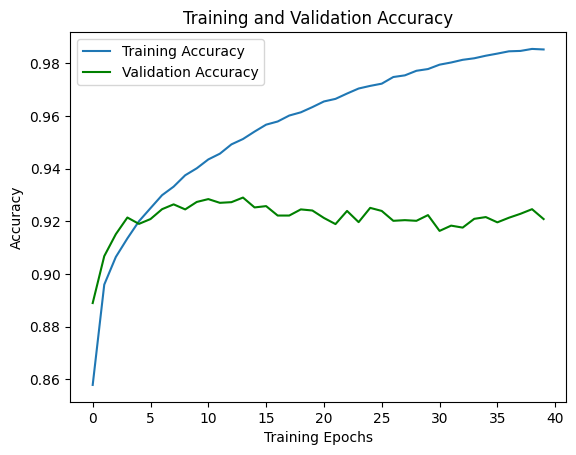

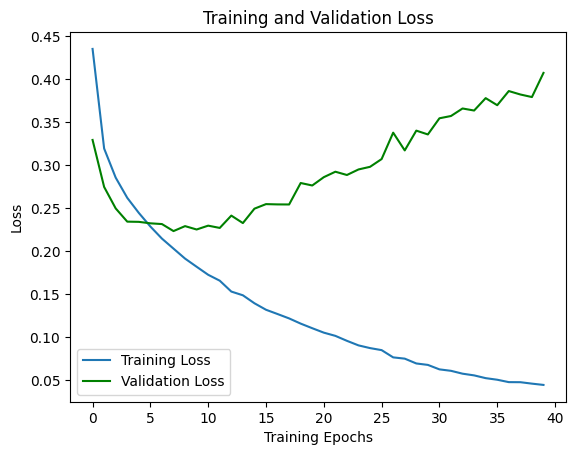

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc, color = 'g')
plt.title ('Training and Validation Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
#plt.savefig('Accuracy.pdf')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss, color = 'g' )
plt.title ('Training and Validation Loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Training Epochs')
plt.ylabel('Loss')

#plt.savefig('Loss.pdf')

## **Test Set Evaluation**

238/238 [==============================] - 4s 10ms/step


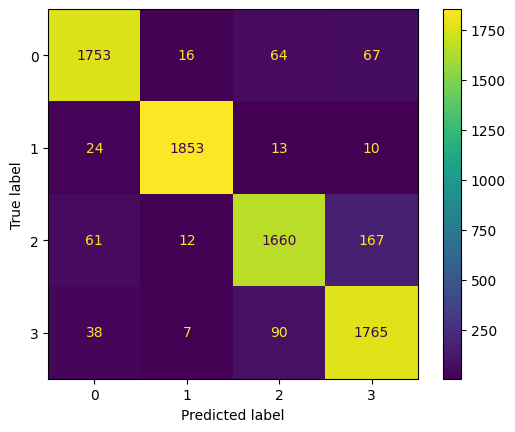

238/238 [==============================] - 3s 14ms/step
ROC_AUC Score: 0.9888555401662049
Cohen_Kappa Score: 0.9001754385964912
F1 Score: 0.925172399961505
Matthews Correlation Coefficient: 0.9003617862142904
Log Loss: 0.23362092652913072
Accuracy: 0.9251315789473684


In [ ]:
num_sentences = 0
test_corpus = []
test_size = 7600
with open("/content/drive/MyDrive/IAR Research Grant/Data/Text Datasets/AG_test.csv", encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        list_item=[]

        #Creating list items where the first item is the text, found in row[0], and the second is the label.
        sentence = row[0]
        list_item.append(sentence)
        list_item.append(row[1])

        num_sentences = num_sentences + 1
        test_corpus.append(list_item)


test_sentences=[]
test_labels=[]
random.shuffle(test_corpus)
for x in range(test_size):
    test_sentences.append(test_corpus[x][0])
    test_labels.append(test_corpus[x][1])

test_word_index = tokenizer.word_index
vocab_size=len(test_word_index)

Test_sequences = tokenizer.texts_to_sequences(test_sentences)
Test_padded = pad_sequences(Test_sequences, padding='post', maxlen = max_length, truncating=trunc_type)

Test_sequences = np.array(Test_padded)
Test_labels = np.array(test_labels)

y_test = lb.fit_transform(Test_labels)

pred = tf.nn.softmax(model.predict(Test_sequences))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_test, axis=1)
Confusion_Matrix = sklearn.metrics.confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

y_pred_proba = tf.nn.softmax(model.predict(Test_sequences))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)